# ESR - Electrical Symbol Recognition using yolov7

In this notebook different custom datasets and model settings will be explored. The pytorch-based implementation provided by the authors of the original yolov7 paper will be used: https://github.com/WongKinYiu/yolov7


#### |
#### |


 
### References
#### Simple guide to get started
*   https://medium.com/mlearning-ai/object-detection-with-yolov7-a74fa1f03c7e


#### Additional command line examples for inference/testing
*   https://blog.paperspace.com/train-yolov7-custom-data/

#### Changing anchor boxes
*   https://towardsdatascience.com/yolov7-a-deep-dive-into-the-current-state-of-the-art-for-object-detection-ce3ffedeeaeb
*   https://github.com/Chris-hughes10/Yolov7-training/



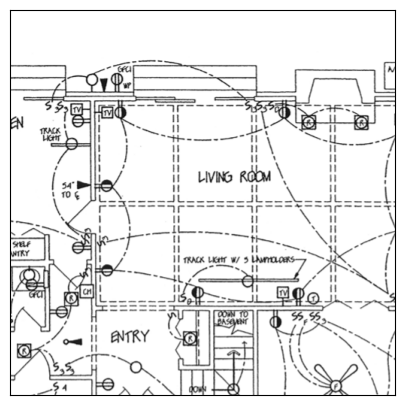

In [ ]:
from utilities import plot_anot_img
plot_anot_img("0007_plan21.png")

In [ ]:
import os
import shutil
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

random_state = 42

In [ ]:
### Starting point

## Original yolov7 implementation in pytorch

In [ ]:
!git clone https://github.com/WongKinYiu/yolov7.git

# download training weights
!wget -qq https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7_training.pt

Cloning into 'yolov7'...
remote: Enumerating objects: 1139, done.
remote: Total 1139 (delta 0), reused 0 (delta 0), pack-reused 1139
Receiving objects: 100% (1139/1139), 70.41 MiB | 14.60 MiB/s, done.
Resolving deltas: 100% (488/488), done.


### Define which data to use to train a model
With imagefiles up to 5429x2573 px in size, some sort of sampling/splitting is necessary. The sampling strategy employed uses a point seed for the top left corner of each potential sample, which may or may not be used directly, depending on if the sample image border intersects a labeled symbol or not. If the sample edge intersects a symbol, random small translations are tested until a sample can succesfully be saved. The process/algorithm that does this can be found in the notebook:

```
extract_symbols_generate_yolo_data.ipynb
```
The appended digits in the names of these 3 zip-files:
*   manual_training_data_000.zip
*   manual_training_data_060.zip
*   manual_training_data_085.zip

...are in reference to a target overlap variable (higher overlap generates more seed points) used when building the training image sets.

While some sort of sampling/splitting is necessary when the imagefiles are up to 5429x2573 px, increasing the sample overlap above some minimum value that ensures that most labeled objects are present in the samples without being   can be used as a sort of data augmentation.

### Testing data
The testing data is generated similarly as the training data, but originate from different plans. Not all of the test image source plan originate from txdot.ftp which is the case with the manually labeled training data

*    manual_test_data.zip

In [ ]:
!gdown -qq 1cd54n-E6oSeFJsgscYPx_kOb4pNf61rj
!unzip -qq manual_test_data.zip
!rm manual_test_data.zip

# manual_training_data_000.zip

In [ ]:
# reset/testing
#
#
#
 
!rm -rf images_manual/
!rm -rf labels_manual/
!rm manual_training_data_000_info.txt
!rm manually_labeled_images.csv

!rm -rf yolov7/train
!rm -rf yolov7/valid
!rm -rf yolov7/test

os.makedirs("yolov7/train/labels"), os.makedirs("yolov7/train/images")
os.makedirs("yolov7/valid/labels"), os.makedirs("yolov7/valid/images")
os.makedirs("yolov7/test/labels"), os.makedirs("yolov7/test/images")

#
#
#
#

(None, None)

In [ ]:
!gdown -qq 1_uqK44fFQu6MFgMce-xiuuWIbxyxSS-9  ## manual 000
!unzip -qq manual_training_data_000.zip

Each line in the .csv file "manually_labeled_images" represents a bounding box present in an image in the dataset.

In [ ]:
df = pd.read_csv("manually_labeled_images.csv")
df.rename(columns={'type':'object_label'}, inplace=True)
df.head(20)

,bbx_id,object_label,xmin,xmax,ymin,ymax,crop_size,image,image_id,has_annotation,class_id
0,0.0,duplex,445.0,477.0,80.0,103.0,512,0000_plan01.png,0.0,True,0.0
1,2.0,duplex,477.0,510.0,99.0,121.0,512,0000_plan01.png,0.0,True,0.0
2,3.0,duplex,445.0,477.0,196.0,219.0,512,0000_plan01.png,0.0,True,0.0
3,4.0,duplex,478.0,509.0,229.0,251.0,512,0000_plan01.png,0.0,True,0.0
4,0.0,duplex,22.0,54.0,115.0,138.0,512,0001_plan01.png,1.0,True,0.0
5,1.0,duplex,100.0,123.0,106.0,138.0,512,0001_plan01.png,1.0,True,0.0
6,2.0,duplex,54.0,87.0,134.0,156.0,512,0001_plan01.png,1.0,True,0.0
7,3.0,duplex,22.0,54.0,231.0,254.0,512,0001_plan01.png,1.0,True,0.0
8,4.0,duplex,55.0,86.0,264.0,286.0,512,0001_plan01.png,1.0,True,0.0
9,5.0,duplex,112.0,134.0,352.0,382.0,512,0001_plan01.png,1.0,True,0.0


There are 4 classes in the dataset:

(-1 is used to denote a background image, the label text file for a background image that is empty)

In [ ]:
print(df["object_label"].unique())
print(df["class_id"].unique())

['duplex' nan 'special' 'quad' 'switch']
[ 0. -1.  2.  1.  3.]


In [ ]:
df.groupby(["object_label"])["bbx_id"].count()

object_label
duplex     417
quad        97
special     12
switch      17
Name: bbx_id, dtype: int64

Each line in the .csv file "manually_labeled_images" represents a bounding box present in an image in the dataset. Using the groupby oiperation we can see that bounding boxes labeled as 'switch' or 'special' are very rare, while 'duplex' and 'quad' are much more common

Additionally, 'special' and 'switch' are only present in 2 parent plans each:

In [ ]:
df["parent_image"] = df.image.apply(lambda x: x[5:11])  # in a couple of instances multiple images have been extracted from the same pdf-file
df[df["object_label"].isin(["switch", "special"])].groupby(["parent_image", "object_label"])["bbx_id"].count()

parent_image  object_label
plan02        special          1
plan03        special         11
plan04        switch           2
plan05        switch          15
Name: bbx_id, dtype: int64

In [ ]:
dfg = pd.concat([df["image"], pd.get_dummies(df["class_id"], "cid")], axis=1)
dfg = dfg.groupby(["image"]).max()
dfg.head()

,cid_-1.0,cid_0.0,cid_1.0,cid_2.0,cid_3.0
image,,,,,
0000_plan01.png,0,1,0,0,0
0001_plan01.png,0,1,0,0,0
0002e_plan01.png,1,0,0,0,0
0003_plan01.png,0,1,0,0,0
0004_plan01.png,0,1,0,0,0


In [ ]:
cid_combination = []
for _, row in dfg.iterrows():
    cid_combination.append(str(row["cid_-1.0"])+"-"+str(row["cid_0.0"])+"-" \
                        + str(row["cid_1.0"])+"-"+str(row["cid_2.0"])+"-" \
                        + str(row["cid_3.0"]))

dfg["cid_combination"] = cid_combination
dfg["cid_combination"].value_counts()

0-1-0-0-0    77
0-1-1-0-0    35
1-0-0-0-0    29
0-0-1-0-0    13
0-1-0-0-1    12
0-1-0-1-0     3
0-1-1-0-1     2
0-0-0-0-1     2
Name: cid_combination, dtype: int64

From the object_labels and class_ids before: 2=special and 3=switch

With that in mind we can decipher that:
*   3 images contain bounding boxes with the '**special**' label 
*   16 (12+2+2) images contain bounding boxes with the '**switch**' label

With so few images there is no real hope in trying to use the special label, let's get rid of it

In [ ]:
# filter the dataframe to only keep rows where cid_2.0 == 0
dfg = dfg[(dfg["cid_2.0"]==0)]


# In the label files, the class_id = 3 previously belonging to 'switch', now (probably) has to be changed to have a value of 2
for labelfile in os.listdir("labels_manual/"):
  with open("labels_manual/"+labelfile, "r") as f:
      lines = f.readlines()
  for i, line in enumerate(lines):
    if line[0] == "3":
      content = "2"+line[1::]
      lines[i] = content

  with open("labels_manual/"+labelfile, "w") as f:
      f.writelines(lines)


### Creating train, validation & test samples
The remaining images can now be sampled in a stratifed fashion, making sure that especially the relatively fewer 'swich' labeles are represented in each set of images (train, validation, test).

This can be done with the well known sklearn train_test_split function, applied in two steps: 

In [ ]:
train_frac = 0.6
valid_frac = 0.25
test_frac = 0.15


x = dfg.index.values
y = dfg["cid_combination"]
train_files, test_files, y_train, y_test = train_test_split(x, y, test_size=test_frac, stratify=y, random_state=42)
train_files, valid_files, y_train, y_valid = train_test_split(train_files, y_train, test_size=valid_frac/(1-test_frac), stratify=y_train, random_state=random_state)

print(f"n train: {len(train_files)}, n valid: {len(valid_files)}, n test: {len(test_files)} (ntot: {len(x)})")

n train: 101, n valid: 43, n test: 26 (ntot: 170)


#### Create utility function to move image and label files based on created sample lists

In [ ]:
def move_images(src_paths, train, valid, test):

  if not os.path.isdir("yolov7/train/labels"): # assume that if 1 directory exists, all exist
    os.makedirs("yolov7/train/labels"), os.makedirs("yolov7/train/images")
    os.makedirs("yolov7/valid/labels"), os.makedirs("yolov7/valid/images")
    os.makedirs("yolov7/test/labels"), os.makedirs("yolov7/test/images")

  for i, file_set in enumerate([train, valid, test]):
    for file in file_set:

        img_src = src_paths[0] + file
        txt_src = src_paths[1] + file[:-4]+".txt"

        if i == 0:
            img_dst = "yolov7/train/images/"+file
            txt_dst = "yolov7/train/labels/"+file[:-4]+".txt"
        elif i == 1:
            img_dst = "yolov7/valid/images/"+file
            txt_dst = "yolov7/valid/labels/"+file[:-4]+".txt"
        else:
            img_dst = "yolov7/test/images/"+file
            txt_dst = "yolov7/test/labels/"+file[:-4]+".txt"

        os.rename(img_src, img_dst)
        os.rename(txt_src, txt_dst)

  shutil.rmtree(src_paths[0])
  shutil.rmtree(src_paths[1])

In [ ]:
src_paths = ["images_manual/", "labels_manual/"]

move_images(src_paths, train_files, valid_files, test_files)

### Making minimal modifications to the model configuration before starting training

In [ ]:
# create a new custom config file by copying "yolov7.yaml...
# and changing line 2 where the number of classes is defined (originally 80 classes)

with open("/content/yolov7/cfg/training/yolov7.yaml", "r") as f:
    content = f.readlines()
    content[1] = "nc: 3  # number of classes\n"

with open("/content/yolov7/cfg/training/esr_v1.yaml", "w") as f:
    f.writelines(content)



# Create file that defines where..
# 1. the training, validation, test samples+labels are located
# 2. the number of classes
# 3. class names

with open("/content/yolov7/data/esr.yaml", "w") as f:
    f.write("train: ./yolov7/train\n")
    f.write("val: ./yolov7/valid\n")
    f.write("test: ./yolov7/test\n\n")
    f.write("# Classes\n")
    f.write("nc: 3  # number of classes\n")
    f.write("names: ['duplex', 'quad', 'switch']")

In [ ]:
run_name = "run_a1"
epochs = 40

!python yolov7/train.py --workers 8 --device 0 --batch-size 32 --weights yolov7_training.pt --data yolov7/data/esr.yaml --img 512 --cfg yolov7/cfg/training/esr_v1.yaml --name $run_name --epochs $epochs

2023-04-20 20:57:43.057521: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 20:57:43.911337: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
YOLOR 🚀 v0.1-122-g3b41c2c torch 2.0.0+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Namespace(weights='yolov7_training.pt', cfg='yolov7/cfg/training/esr_v1.yaml', data='yolov7/data/esr.yaml', hyp='./yolov7/data/hyp.scratch.p5.yaml', epochs=40, batch_size=32, img_size=[512, 512], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket='', cache_images=False, image_weights=False, device='0', multi_scale=False, single_cls=False, adam=False, sync_bn=False, local_rank=-1, workers=8, project='runs/train', entity=None, name='run_a1',

In [ ]:
run_name = "run_a2"
epochs = 80

!python yolov7/train.py --workers 8 --device 0 --batch-size 32 --weights yolov7_training.pt --data yolov7/data/esr.yaml --img 512 --cfg yolov7/cfg/training/esr_v1.yaml --name $run_name --epochs $epochs

2023-04-20 21:06:00.903213: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 21:06:02.727960: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
YOLOR 🚀 v0.1-122-g3b41c2c torch 2.0.0+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Namespace(weights='yolov7_training.pt', cfg='yolov7/cfg/training/esr_v1.yaml', data='yolov7/data/esr.yaml', hyp='./yolov7/data/hyp.scratch.p5.yaml', epochs=80, batch_size=32, img_size=[512, 512], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket='', cache_images=False, image_weights=False, device='0', multi_scale=False, single_cls=False, adam=False, sync_bn=False, local_rank=-1, workers=8, project='runs/train', entity=None, name='run_a2',

In [ ]:
# save the best weights and other run outputs
run_zip = run_name+".zip"
basepath = "runs/train/"
wghts = "/weights"
best_wghts = "/best.pt"

!cp $basepath$run_name$wghts$best_wghts $basepath$run_name$best_wghts
!rm -rf $basepath$run_name$wghts
!cp -r $basepath$run_name $run_name
!rm -rf $basepath$run_name

!zip -qq -r $run_zip $run_name
from google.colab import files
files.download(run_zip)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# # download run_a2 directory with weights
# run_name = "run_a2"
# !gdown -qq 1sfBkzzJrtql8veqNL0-2Y-Wgrzw92CWK
# !unzip -qq run_a2

In [ ]:
run_name_inf = run_name+"_inf"  # inference run name
src_images = "yolov7/test/images"
best_wght_path = run_name+"/best.pt"

!python yolov7/detect.py --source $src_images --save-txt --weights $best_wght_path --conf 0.25 --name $run_name_inf --no-trace

Namespace(weights=['run_a2/best.pt'], source='yolov7/test/images', img_size=640, conf_thres=0.25, iou_thres=0.45, device='', view_img=False, save_txt=True, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='run_a2_inf', exist_ok=False, no_trace=False)
YOLOR 🚀 v0.1-122-g3b41c2c torch 2.0.0+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
Model Summary: 314 layers, 36492560 parameters, 6194944 gradients
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
12 duplexs, Done. (22.0ms) I

In [ ]:
# save the images
run_inf_zip = run_name_inf+".zip"
basepath = "runs/detect/"

!cp -r $basepath$run_name_inf $run_name_inf
!rm -rf $basepath$run_name_inf

# !zip -qq -r $run_inf_zip $run_name_inf
from google.colab import files
files.download(run_inf_zip)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# cleanup after run_a2
!rm -r run_a2
!rm -r run_a2_inf
!rm run_a2.zip
!rm run_a2_inf.zip
!rm manual_training_data_000.zip
!rm manual_training_data_000_info.txt
!rm manually_labeled_images.csv

!rm -r yolov7/train
!rm -r yolov7/valid
!rm -r yolov7/test

# manual_training_data_060.zip

In [ ]:
!gdown -qq 1KSj9Rqa2E87IiAkvREyhKXObCOT6Xbbx
!unzip -qq manual_training_data_060.zip

In [ ]:
df = pd.read_csv("manually_labeled_images.csv")
df.rename(columns={'type':'object_label'}, inplace=True)
df.groupby(["object_label"])["bbx_id"].count()

object_label
duplex     1949
quad        437
special      35
switch       92
Name: bbx_id, dtype: int64

In this larger image set there are 35 bounding boxes with the 'special' label

In [ ]:
dfg = pd.concat([df["image"], pd.get_dummies(df["class_id"], "cid")], axis=1)
dfg = dfg.groupby(["image"]).max()

cid_combination = []
for _, row in dfg.iterrows():
    cid_combination.append(str(row["cid_-1.0"])+"-"+str(row["cid_0.0"])+"-" \
                        + str(row["cid_1.0"])+"-"+str(row["cid_2.0"])+"-" \
                        + str(row["cid_3.0"]))

dfg["cid_combination"] = cid_combination
dfg["cid_combination"].value_counts()

0-1-0-0-0    332
0-1-1-0-0    183
1-0-0-0-0    133
0-1-0-0-1     59
0-0-1-0-0     55
0-0-0-0-1     15
0-1-0-1-0     10
0-0-1-0-1      4
0-0-0-1-0      2
0-1-1-1-0      1
0-1-1-0-1      1
Name: cid_combination, dtype: int64

From the object_labels and class_ids shown before: 2=special and 3=switch. With that we can decipher that:
*   13 (10+2+1) images contain bounding boxes with the '**special**' label 
*   79 (59+15+4+1) images contain bounding boxes with the '**switch**' label

Just like before, let's get rid of the switch label.


In [ ]:
# filter the dataframe to only keep rows where cid_2.0 == 0
dfg = dfg[(dfg["cid_2.0"]==0)]


# there is only 1 image with class id combination (cid_combination) "0-1-1-0-1", changing that manually to "0-0-1-0-1"
idx = dfg[dfg["cid_combination"]=="0-1-1-0-1"].index
dfg.loc[idx, "cid_combination"] = "0-0-1-0-1"


# In the label files, the class_id = 3 previously belonging to 'switch', now (probably) has to be changed to have a value of 2
for labelfile in os.listdir("labels_manual/"):
  with open("labels_manual/"+labelfile, "r") as f:
      lines = f.readlines()
  for i, line in enumerate(lines):
    if line[0] == "3":
      content = "2"+line[1::]
      lines[i] = content

  with open("labels_manual/"+labelfile, "w") as f:
      f.writelines(lines)

### Creating train, validation & test samples (like before)

In [ ]:
train_frac = 0.6
valid_frac = 0.25
test_frac = 0.15

x = dfg.index.values
y = dfg["cid_combination"]
train_files, test_files, y_train, y_test = train_test_split(x, y, test_size=test_frac, stratify=y, random_state=42)
train_files, valid_files, y_train, y_valid = train_test_split(train_files, y_train, test_size=valid_frac/(1-test_frac), stratify=y_train, random_state=random_state)

print(f"n train: {len(train_files)}, n valid: {len(valid_files)}, n test: {len(test_files)} (ntot: {len(x)})")

n train: 468, n valid: 196, n test: 118 (ntot: 782)


In [ ]:
src_paths = ["images_manual/", "labels_manual/"]

move_images(src_paths, train_files, valid_files, test_files)

### Making minimal modifications to the model configuration before starting training (like before)

In [ ]:
# create a new custom config file by copying "yolov7.yaml...
# and changing line 2 where the number of classes is defined (originally 80 classes)

with open("/content/yolov7/cfg/training/yolov7.yaml", "r") as f:
    content = f.readlines()
    content[1] = "nc: 3  # number of classes\n"

with open("/content/yolov7/cfg/training/esr_v1.yaml", "w") as f:
    f.writelines(content)


# Create file that defines where..
# 1. the training, validation, test samples+labels are located
# 2. the number of classes
# 3. class names

with open("/content/yolov7/data/esr.yaml", "w") as f:
    f.write("train: ./yolov7/train\n")
    f.write("val: ./yolov7/valid\n")
    f.write("test: ./yolov7/test\n\n")
    f.write("# Classes\n")
    f.write("nc: 3  # number of classes\n")
    f.write("names: ['duplex', 'quad', 'switch']")

In [ ]:
run_name = "run_b1"
epochs = 40

!python yolov7/train.py --workers 8 --device 0 --batch-size 32 --weights yolov7_training.pt --data yolov7/data/esr.yaml --img 512 --cfg yolov7/cfg/training/esr_v1.yaml --name $run_name --epochs $epochs

2023-04-21 15:02:34.239377: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-21 15:02:36.049046: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
YOLOR 🚀 v0.1-122-g3b41c2c torch 2.0.0+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Namespace(weights='yolov7_training.pt', cfg='yolov7/cfg/training/esr_v1.yaml', data='yolov7/data/esr.yaml', hyp='./yolov7/data/hyp.scratch.p5.yaml', epochs=40, batch_size=32, img_size=[512, 512], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket='', cache_images=False, image_weights=False, device='0', multi_scale=False, single_cls=False, adam=False, sync_bn=False, local_rank=-1, workers=8, project='runs/train', entity=None, name='

In [ ]:
# save the best weights and other run outputs
run_zip = run_name+".zip"
basepath = "runs/train/"
wghts = "/weights"
best_wghts = "/best.pt"

!cp $basepath$run_name$wghts$best_wghts $basepath$run_name$best_wghts
!rm -rf $basepath$run_name$wghts
!cp -r $basepath$run_name $run_name
!rm -rf $basepath$run_name

!zip -qq -r $run_zip $run_name
from google.colab import files
files.download(run_zip)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# # download run_b1 directory with weights
# run_name = "run_b1"
# !gdown -qq 1kA4VVOgiAavMMXl6lzE9xBSWko7PQ_Su
# !unzip -qq run_b1

### Test b1

In [ ]:
run_name_test = run_name+"_test"  # test run name
src_images = "yolov7/test/images"
best_wght_path = run_name+"/best.pt"

!python yolov7/test.py --weights $best_wght_path --data yolov7/data/esr.yaml --img-size 512 --save-txt --task test --name $run_name_test

Namespace(weights=['run_b1/best.pt'], data='yolov7/data/esr.yaml', batch_size=32, img_size=512, conf_thres=0.001, iou_thres=0.65, task='test', device='', single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=False, save_json=False, project='runs/test', name='run_b1_test', exist_ok=False, no_trace=False, v5_metric=False)
YOLOR 🚀 v0.1-122-g3b41c2c torch 2.0.0+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
Model Summary: 314 layers, 36492560 parameters, 6194944 gradients
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-d

In [ ]:
# save test output




### Inference b1

In [ ]:
run_name_inf = run_name+"_inf"  # inference run name
src_images = 
best_wght_path = run_name+"/best.pt"

!python yolov7/detect.py --source $src_images --save-txt --weights $best_wght_path --conf 0.25 --name $run_name_inf --no-trace

In [ ]:
# cleanup after run_b1
!rm -r run_b1
!rm -r run_b1_inf
!rm run_b1.zip
!rm run_b1_inf.zip
!rm manual_training_data_060.zip
!rm manual_training_data_060_info.txt
!rm manually_labeled_images.csv

!rm -r yolov7/train
!rm -r yolov7/valid
!rm -r yolov7/test

rm: cannot remove 'run_b1_inf': No such file or directory
rm: cannot remove 'run_b1_inf.zip': No such file or directory


# manual_training_data_085.zip

In [ ]:
!gdown -qq 1IsGbvCtZ-b_CO8efTnbBQEtC1DlyNSCw
!unzip -qq manual_training_data_085.zip

In [ ]:
df = pd.read_csv("manually_labeled_images.csv")
df.rename(columns={'type':'object_label'}, inplace=True)
df.groupby(["object_label"])["bbx_id"].count()

object_label
duplex     11505
quad        2807
special      178
switch       525
Name: bbx_id, dtype: int64

In this signifcantly larger image set there are about 15000 total bounding boxes+ labels, 178 out of them are labeled 'special'

In [ ]:
dfg = pd.concat([df["image"], pd.get_dummies(df["class_id"], "cid")], axis=1)
dfg = dfg.groupby(["image"]).max()

cid_combination = []
for _, row in dfg.iterrows():
    cid_combination.append(str(row["cid_-1.0"])+"-"+str(row["cid_0.0"])+"-" \
                        + str(row["cid_1.0"])+"-"+str(row["cid_2.0"])+"-" \
                        + str(row["cid_3.0"]))

dfg["cid_combination"] = cid_combination
dfg["cid_combination"].value_counts()

0-1-0-0-0    2041
0-1-1-0-0    1188
1-0-0-0-0     814
0-1-0-0-1     324
0-0-1-0-0     311
0-0-0-0-1     101
0-1-0-1-0      46
0-1-1-0-1      25
0-0-1-0-1      18
0-0-0-1-0       8
0-1-1-1-0       7
0-0-1-1-0       1
Name: cid_combination, dtype: int64

There is only 1 image with class id combination (cid_combination) "0-0-1-1-0", just like before this has to be manually changed to another existing combination (here, "0-1-1-1-0")


In [ ]:
# there is only 1 image with class id combination (cid_combination) "0-1-1-0-1", changing that manually to "0-0-1-0-1"
idx = dfg[dfg["cid_combination"]=="0-0-1-1-0"].index
dfg.loc[idx, "cid_combination"] = "0-1-1-1-0"

### Creating train, validation & test samples (like before)

In [ ]:
train_frac = 0.6
valid_frac = 0.25
test_frac = 0.15

x = dfg.index.values
y = dfg["cid_combination"]
train_files, test_files, y_train, y_test = train_test_split(x, y, test_size=test_frac, stratify=y, random_state=42)
train_files, valid_files, y_train, y_valid = train_test_split(train_files, y_train, test_size=valid_frac/(1-test_frac), stratify=y_train, random_state=random_state)

print(f"n train: {len(train_files)}, n valid: {len(valid_files)}, n test: {len(test_files)} (ntot: {len(x)})")

n train: 2930, n valid: 1221, n test: 733 (ntot: 4884)


In [ ]:
src_paths = ["images_manual/", "labels_manual/"]

move_images(src_paths, train_files, valid_files, test_files)

### Making minimal modifications to the model configuration before starting training (like before)

In [ ]:
# create a new custom config file by copying "yolov7.yaml...
# and changing line 2 where the number of classes is defined (originally 80 classes)

with open("/content/yolov7/cfg/training/yolov7.yaml", "r") as f:
    content = f.readlines()
    content[1] = "nc: 4  # number of classes\n"

with open("/content/yolov7/cfg/training/esr_v1.yaml", "w") as f:
    f.writelines(content)


# Create file that defines where..
# 1. the training, validation, test samples+labels are located
# 2. the number of classes
# 3. class names

with open("/content/yolov7/data/esr.yaml", "w") as f:
    f.write("train: ./yolov7/train\n")
    f.write("val: ./yolov7/valid\n")
    f.write("test: ./yolov7/test\n\n")
    f.write("# Classes\n")
    f.write("nc: 4  # number of classes\n")
    f.write("names: ['duplex', 'quad', 'special', 'switch']")

In [ ]:
run_name = "run_c1"
epochs = 30

!python yolov7/train.py --workers 8 --device 0 --batch-size 32 --weights yolov7_training.pt --data yolov7/data/esr.yaml --img 512 --cfg yolov7/cfg/training/esr_v1.yaml --name $run_name --epochs $epochs

2023-04-21 17:52:09.412360: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-21 17:52:10.684158: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
YOLOR 🚀 v0.1-122-g3b41c2c torch 2.0.0+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Namespace(weights='yolov7_training.pt', cfg='yolov7/cfg/training/esr_v1.yaml', data='yolov7/data/esr.yaml', hyp='./yolov7/data/hyp.scratch.p5.yaml', epochs=30, batch_size=32, img_size=[512, 512], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket='', cache_images=False, image_weights=False, device='0', multi_scale=False, single_cls=False, adam=False, sync_bn=False, local_rank=-1, workers=8, project='runs/train', entity=None, name='run_c1',

In [ ]:
# save the best weights and other run outputs
run_zip = run_name+".zip"
basepath = "runs/train/"
wghts = "/weights"
best_wghts = "/best.pt"

!cp $basepath$run_name$wghts$best_wghts $basepath$run_name$best_wghts
!rm -rf $basepath$run_name$wghts
!cp -r $basepath$run_name $run_name
!rm -rf $basepath$run_name

!zip -qq -r $run_zip $run_name
from google.colab import files
files.download(run_zip)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!gdown -qq 13ZPw7oAs8HOf9SV3AGRqfcBawGSaBuFL # auto_generated_training_set3.zip
!unzip -qq auto_generated_training_set3.zip

In [ ]:
# move folders into the yolov7 directory
# import shutil
# shutil.move("test/", "yolov7/test/", copy_function = shutil.copytree)
# shutil.move("train/", "yolov7/train/", copy_function = shutil.copytree)
# shutil.move("valid/", "yolov7/valid/", copy_function = shutil.copytree)

In [ ]:
\Ntot = len(os.listdir("generated_data/images"))
print(f"Total number of generated images: {Ntot}")

Total number of generated images: 4742


In [ ]:
# copy N generated images and labels into the train, valid and test folders inside the yolo-directrory 
import random

src_filelist = os.listdir("generated_data/images")


# for i in range(Ntot):
#   for img_set in ["train", "valid", "test"]:
#     file_list = img_setrandom.choice(os.listdir(img_set+"/images"))

#     train_img_path = img_set+"/images"+rand_file
#     train_lbl_path = img_set+"/labels"+rand_file[:-4]+".txt"
#     # os.rename(train_img_path, "yolov7/"+train_img_path)
#     # os.rename(train_lbl_path, "yolov7/"+train_lbl_path)


In [ ]:
# change the default anchor boxes
#
#
#
#

In [ ]:
# modify hyperparameter file to reduce wight of classification loss
#
#
#
#

### Training (terminal)

In [ ]:
# save the best weights and other run outputs
run_zip = run_name+".zip"
basepath = "runs/train/"
wghts = "/weights"
best_wghts = "/best.pt"

!cp $basepath$run_name$wghts$best_wghts $basepath$run_name$best_wghts
!rm -rf $basepath$run_name$wghts
!cp -r $basepath$run_name $run_name
!rm -rf $basepath$run_name

!zip -qq -r $run_zip $run_name
from google.colab import files
files.download(run_zip)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# cleanup
!rm -rf $run_name

### Testing (terminal)